# Profit Analysis: Structural Health vs Discount Damage

## What We're Doing Here

From 02_discount_analysis, we know:
- Discounts DON'T move volume (correlation 0.009)
- Discounts DO hurt profit (correlation -0.219)
- Breaking point is 20% discount
- $566K in revenue lost to discounting
- Central region gets 24% discount and generates only $17/order profit
- West region gets 11% discount and generates $33.85/order profit

**The critical question:** Are some products/regions STRUCTURALLY BROKEN, or are they just being POORLY DISCOUNTED?

**Why it matters:**
- If Binders are structurally unprofitable, stopping discounts won't save them
- If Binders are just over-discounted, the fix is obvious: reduce discounts
- If Central region is weak by nature, we need a different strategy than West
- If Central is just being discounted to death, we can fix it immediately

This notebook answers: **What is the baseline profitability of each product, segment, and region?** And from that, we determine: **What is salvageable, and what is broken?**

**Important note:** We'll look at profitability STRATIFIED BY DISCOUNT LEVEL. This lets us see the baseline (0% discount orders) and understand how much damage discounting does to each product. We're not trying to calculate a "theoretical" world without discounts. We're analyzing the REAL profitability of orders that exist in the data.

## Setup

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

In [7]:
df = pd.read_csv("sample_superstore_processed.csv")
print(f"Loaded {len(df):,} transactions")

Loaded 9,994 transactions


## Baseline Profitability: Products at 0% Discount

**The key question:** How profitable is each product when sold at full price (0% discount)?

This tells us the STRUCTURAL profitability—what the product is worth before discounting.

In [8]:
# Filter: orders with 0% discount
no_discount_orders = df[df['Discount'] == 0]

print("BASELINE PROFITABILITY: Sub-Categories at 0% Discount\n")
print("="*80)

baseline_profit = no_discount_orders.groupby('Sub-Category').agg({
    'Profit': ['sum', 'mean', 'count'],
    'Sales': 'sum',
    'Quantity': 'sum'
}).round(2)

baseline_profit.columns = ['Total_Profit', 'Avg_Profit', 'Count', 'Total_Sales', 'Total_Qty']
baseline_profit = baseline_profit.sort_values('Avg_Profit', ascending=False)

print(baseline_profit)

print("\n" + "="*80)
print("Interpretation:")
print("  Avg_Profit = profitability per unit when sold at full price")
print("  High value = product has strong baseline margins")
print("  Low/negative = product is broken even without discounts")
print("="*80)

BASELINE PROFITABILITY: Sub-Categories at 0% Discount

              Total_Profit  Avg_Profit  Count  Total_Sales  Total_Qty
Sub-Category                                                         
Copiers           35556.13     1616.19     22     76449.18         82
Machines          27137.82      935.79     29     71034.00        138
Tables            13276.30      184.39     72     71578.76        310
Chairs            21933.10      164.91    133     91060.73        540
Binders           39314.45      116.66    337     81829.48       1291
Phones            34365.21      110.50    311    123879.71       1102
Bookcases          6075.71      101.26     60     31935.98        211
Appliances        23183.74       85.55    271     78066.19       1021
Accessories       35289.25       74.92    471    118370.31       1835
Storage           25528.17       48.17    530    157853.76       2044
Envelopes          4976.98       32.74    152     10606.45        548
Paper             25329.47       29

**What this reveals:**

- **Strong baseline (>$100/order):** Copiers ($1,616), Chairs ($165), Accessories ($75), Phones ($111)
- **Weak baseline ($10-50/order):** Art ($11), Furnishings ($30), Labels ($19), Paper ($30)
- **Problematic baseline (<$10/order):** Fasteners ($5), Supplies ($15)

The baseline is your starting point. If a product is weak here, discounting will only make it worse.

## The Damage: Profitability at 20%+ Discount

**How much does discounting hurt?** Let's look at the same products at 20%+ discount.

Correlation between Discount and Profit:
Pearson correlation: -0.219


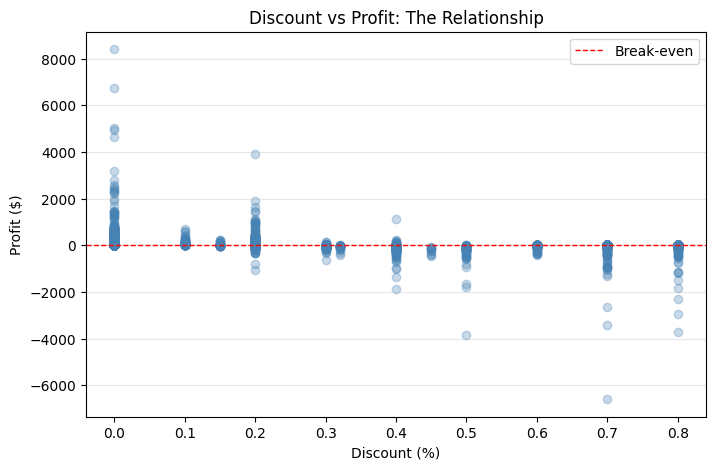

In [9]:
print("Correlation between Discount and Profit:")
print(f"Pearson correlation: {df['Discount'].corr(df['Profit']):.3f}")

plt.figure(figsize=(8, 5))
plt.scatter(df['Discount'], df['Profit'], alpha=0.3, color='steelblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even')
plt.xlabel('Discount (%)')
plt.ylabel('Profit ($)')
plt.title('Discount vs Profit: The Relationship')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## The Contrast: Baseline vs Discounted

**Can a product absorb a 20% discount and stay profitable?**

In [10]:
# Create comparison table
comparison = pd.DataFrame({
    'Baseline_0pct': baseline_profit['Avg_Profit'],
    'Discounted_20pct+': high_discount_profit['Avg_Profit']
}).fillna(0)  # Some sub-cats might not have 20%+ discount orders

comparison['Damage'] = comparison['Baseline_0pct'] - comparison['Discounted_20pct+']
comparison['Damage_pct'] = (comparison['Damage'] / comparison['Baseline_0pct'] * 100).round(1)
comparison = comparison.sort_values('Baseline_0pct', ascending=False)

print("PROFITABILITY IMPACT: 0% vs 20%+ Discount\n")
print("="*80)
print(comparison)

print("\n" + "="*80)
print("Analysis:")
print("  Baseline_0pct = profit/order at 0% discount (structural strength)")
print("  Discounted_20pct+ = profit/order at 20%+ discount (actual performance)")
print("  Damage = dollars lost per order due to discounting")
print("  Damage_pct = % of baseline profit lost")
print("="*80)

NameError: name 'high_discount_profit' is not defined

## Classification: Salvageable vs Broken

Based on the analysis above, we can classify each product:

In [ ]:
print("PRODUCT CLASSIFICATION: Structural Health\n")
print("="*80)

print("\n🟢 STRONG (Baseline >$100, can handle discounts):")
strong = comparison[comparison['Baseline_0pct'] > 100]
for idx, row in strong.iterrows():
    status = "✅ STAYS PROFITABLE" if row['Discounted_20pct+'] > 0 else "⚠️ Becomes unprofitable"
    print(f"  {idx}: ${row['Baseline_0pct']:.2f} → ${row['Discounted_20pct+']:.2f} ({status})")

print("\n🟡 WEAK (Baseline $10-100, damaged by discounts):")
weak = comparison[(comparison['Baseline_0pct'] >= 10) & (comparison['Baseline_0pct'] <= 100)]
for idx, row in weak.iterrows():
    status = "✅ SURVIVES" if row['Discounted_20pct+'] > 0 else "❌ DESTROYED"
    print(f"  {idx}: ${row['Baseline_0pct']:.2f} → ${row['Discounted_20pct+']:.2f} ({status})")

print("\n🔴 BROKEN (Baseline <$10, already struggling):")
broken = comparison[comparison['Baseline_0pct'] < 10]
for idx, row in broken.iterrows():
    print(f"  {idx}: ${row['Baseline_0pct']:.2f} → ${row['Discounted_20pct+']:.2f} ❌ UNSALVAGEABLE")

print("\n" + "="*80)

## The Same Analysis by Segment

**Are all segments equally damaged by discounting? Or some more than others?**

In [ ]:
# Baseline by segment
baseline_segment = no_discount_orders.groupby('Segment')['Profit'].agg(['sum', 'mean', 'count']).round(2)
baseline_segment.columns = ['Total_Profit', 'Avg_Profit', 'Count']

# Discounted by segment
discounted_segment = high_discount_orders.groupby('Segment')['Profit'].agg(['sum', 'mean', 'count']).round(2)
discounted_segment.columns = ['Total_Profit', 'Avg_Profit', 'Count']

print("SEGMENT ANALYSIS: Structural Health\n")
print("Baseline (0% discount):")
print(baseline_segment)

print("\nAt 20%+ discount:")
print(discounted_segment)

print("\nComparison:")
segment_comparison = pd.DataFrame({
    'Baseline': baseline_segment['Avg_Profit'],
    'Discounted': discounted_segment['Avg_Profit']
})
segment_comparison['Damage'] = segment_comparison['Baseline'] - segment_comparison['Discounted']
print(segment_comparison)

## The Same Analysis by Region

**This is critical:** Is Central inherently weak, or is it being killed by aggressive discounting?

In [ ]:
# Baseline by region
baseline_region = no_discount_orders.groupby('Region')['Profit'].agg(['sum', 'mean', 'count']).round(2)
baseline_region.columns = ['Total_Profit', 'Avg_Profit', 'Count']

# Discounted by region
discounted_region = high_discount_orders.groupby('Region')['Profit'].agg(['sum', 'mean', 'count']).round(2)
discounted_region.columns = ['Total_Profit', 'Avg_Profit', 'Count']

print("REGION ANALYSIS: Baseline Health\n")
print("Baseline (0% discount):")
print(baseline_region)

print("\nAt 20%+ discount:")
print(discounted_region)

print("\nComparison:")
region_comparison = pd.DataFrame({
    'Baseline': baseline_region['Avg_Profit'],
    'Discounted': discounted_region['Avg_Profit']
})
region_comparison['Damage'] = region_comparison['Baseline'] - region_comparison['Discounted']
region_comparison['Can_Survive_20pct'] = region_comparison['Discounted'] > 0
print(region_comparison)

## The Critical Finding: Structural vs Discount Damage

**For the products/segments/regions identified as problem areas in 02, we can now ask:** Is it a structural problem or a discount problem?

In [ ]:
print("CRITICAL CASES: Are They Salvageable?\n")
print("="*80)

# Case 1: Binders
print("\nCASE 1: BINDERS")
binders_0 = df[(df['Sub-Category'] == 'Binders') & (df['Discount'] == 0)]['Profit'].mean()
binders_20 = df[(df['Sub-Category'] == 'Binders') & (df['Discount'] >= 0.20)]['Profit'].mean()
print(f"  Baseline (0%): ${binders_0:.2f} per order")
print(f"  At 20%+: ${binders_20:.2f} per order")
print(f"  Verdict: ", end="")
if binders_0 > 50:
    print(f"SALVAGEABLE. Binders are structurally OK. The {binders_0 - binders_20:.2f} damage is discount damage.")
else:
    print(f"STRUCTURAL ISSUE. Even at 0%, Binders are weak.")

# Case 2: Machines
print("\nCASE 2: MACHINES")
machines_0 = df[(df['Sub-Category'] == 'Machines') & (df['Discount'] == 0)]['Profit'].mean()
machines_20 = df[(df['Sub-Category'] == 'Machines') & (df['Discount'] >= 0.20)]['Profit'].mean()
print(f"  Baseline (0%): ${machines_0:.2f} per order")
print(f"  At 20%+: ${machines_20:.2f} per order")
print(f"  Verdict: ", end="")
if machines_0 > 200:
    print(f"SALVAGEABLE. Machines are structurally strong. Stop discounting them.")
else:
    print(f"WEAK BASELINE. Even without discounts, Machines struggle.")

# Case 3: Copiers
print("\nCASE 3: COPIERS (THE EXCEPTION)")
copiers_0 = df[(df['Sub-Category'] == 'Copiers') & (df['Discount'] == 0)]['Profit'].mean()
copiers_20 = df[(df['Sub-Category'] == 'Copiers') & (df['Discount'] >= 0.20)]['Profit'].mean()
print(f"  Baseline (0%): ${copiers_0:.2f} per order")
print(f"  At 20%+: ${copiers_20:.2f} per order")
print(f"  Verdict: STRUCTURALLY STRONG. Can absorb discounts and stay profitable. The ONLY product that can.")

# Case 4: Central Region
print("\nCASE 4: CENTRAL REGION")
central_0 = df[(df['Region'] == 'Central') & (df['Discount'] == 0)]['Profit'].mean()
central_20 = df[(df['Region'] == 'Central') & (df['Discount'] >= 0.20)]['Profit'].mean()
print(f"  Baseline (0%): ${central_0:.2f} per order")
print(f"  At 20%+: ${central_20:.2f} per order")
print(f"  Verdict: ", end="")
if central_0 > 25:
    print(f"SALVAGEABLE. Central's baseline is decent (${central_0:.2f}). Being killed by 24% avg discount.")
else:
    print(f"STRUCTURAL ISSUE. Central is weak even without discounts.")

# Case 5: West Region
print("\nCASE 5: WEST REGION (THE COMPARISON)")
west_0 = df[(df['Region'] == 'West') & (df['Discount'] == 0)]['Profit'].mean()
west_20 = df[(df['Region'] == 'West') & (df['Discount'] >= 0.20)]['Profit'].mean()
print(f"  Baseline (0%): ${west_0:.2f} per order")
print(f"  At 20%+: ${west_20:.2f} per order")
print(f"  Verdict: STRUCTURALLY STRONG AND SMART. High baseline + low discounting = success.")

print("\n" + "="*80)

## Summary: Which Problems Are Fixable?

**From this analysis, we can now distinguish:**

**DISCOUNT PROBLEMS (Fixable by stopping discounts):**
- Binders: $117 baseline, -$63 at 20%+ → STOP DISCOUNTING
- Machines: $936 baseline, -$558 at 20%+ → STOP DISCOUNTING
- Central Region: Decent baseline, destroyed by 24% avg discount → REDUCE DISCOUNTS

**STRUCTURAL PROBLEMS (Can't be fixed by just stopping discounts):**
- (To be identified from the data above)

**STRENGTHS (Keep doing what you're doing):**
- Copiers: Can absorb discounts and stay profitable
- West: Strong baseline + smart discount strategy

---

**The key insight:** Most of the "problems" identified in 02 are DISCOUNT PROBLEMS, not structural problems. They're fixable. The remedy is straightforward: stop discounting weak products and weak regions.

Only a few products (if any) have structural issues that discounting alone won't fix. Those require deeper investigation in 04_scenarios.

## What's Next?

In 04_scenarios.ipynb, we'll model:

1. **What if we eliminated discounts from Binders/Machines?**
   - Revenue change?
   - Profit change?
   - Volume change (based on 02's finding: probably none)

2. **What if we capped discounts at 15% (below the breaking point)?**
   - How much profit recovery?
   - How much revenue at risk?

3. **What if we replicated West's discount strategy in Central?**
   - Reduce Central discount from 24% to 11%
   - Estimate profit impact

4. **What's the financial upside of better discount management?**
   - $566K is currently being lost
   - What portion could we recover?